# **[ Modeling Flow ]**
### **1. Library Import**
### **2. Data Import**  
### **3. Tabular data 전처리 - 정보 확인(info / describe), null값 처리, 인코딩, 이상치 처리, 정규화**
### **4. Image data 전처리 - resize, crop, resolution 조절, 픽셀화, flatten, 정규화**
### **5. Model 생성**
### **6. 학습/예측/평가**

# **Zoobot Import**

In [ ]:
!git clone https://github.com/mwalmsley/zoobot.git
!pip install zoobot[pytorch-colab] -q
!pip install albumentations==1.4.24

fatal: destination path 'zoobot' already exists and is not an empty directory.


# **Library Import**

In [ ]:
import logging
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

import numpy as np
import pandas as pd
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from pytorch_lightning.callbacks import Callback

from zoobot.pytorch.training.finetune import FinetuneableZoobotAbstract

logging.basicConfig(level=logging.INFO)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Import**

In [ ]:
import json

file_path = '/content/drive/MyDrive/Galaxy_Merger'

data = []
with open(file_path+"/galaxy_samples/sample_dataset.jsonl", 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# 첫 3개만 출력해보기
print(data[:3])

[{'ID': 482215.0, 'snapshot': 91.0, 'imagefile': "subhalo482215_91.png'", 'data': {'mass': 38079471765.888885, 'SFR': 9.699098521619943, 'redshift': 0.03629301836816964}, 'phase': 0.0}, {'ID': 663001.0, 'snapshot': 91.0, 'imagefile': "subhalo663001_91.png'", 'data': {'mass': 95120716334.5817, 'SFR': 8.324426408004218, 'redshift': 0.04297256589643226}, 'phase': 0.0}, {'ID': 407765.0, 'snapshot': 91.0, 'imagefile': "'subhalo407765_91.png'", 'data': {'mass': 73467400239.3291, 'SFR': 2.1233911067827616, 'redshift': 0.05104629857953324}, 'phase': 1.0}]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 1 to 9
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   imagefile  9 non-null      object 
 1   phase      9 non-null      float64
 2   mass       9 non-null      float64
 3   SFR        9 non-null      float64
 4   redshift   9 non-null      float64
dtypes: float64(4), object(1)
memory usage: 492.0+ bytes


In [ ]:
df = pd.json_normalize(data)

df = df.drop(index=10)
df = df.drop(['snapshot', 'ID'], axis=1)

df.columns = [col.replace('data.', '') for col in df.columns]

sample_data = df.iloc[0]
df = df.drop(index=0)

df.head(9)

,imagefile,phase,mass,SFR,redshift
1,subhalo663001_91.png',0.0,9.512072e+10,8.324426,0.042973
2,'subhalo407765_91.png',1.0,7.346740e+10,2.123391,0.051046
3,'subhalo413298_91.png',1.0,6.026719e+10,1.818250,0.080666
4,'subhalo461023_91.png',1.0,1.644585e+10,1.834045,0.027971
5,'subhalo472172_91.png',1.0,1.644346e+10,3.042422,0.056281
6,'subhalo156816_91.png',-1.0,6.750278e+09,5.247564,0.063317
7,'subhalo350921_91.png',-1.0,8.675144e+10,4.319450,0.014181
8,'subhalo324737_91.png',-1.0,6.051039e+10,2.912291,0.064679
9,'subhalo359187_91.png',-1.0,7.109919e+10,6.118529,0.025347


In [ ]:
# tabular columns 저장
df_tab_cols = df.select_dtypes(include=['int64', 'float64']).copy().drop('phase', axis=1)

# label 저장 - 0 : ongoing, 1 : post-merger 2: pre-merger
df_label_col = df['phase'].replace(-1, 2).astype(int)

# 이미지 경로 저장
df_img_paths = df['imagefile'].str.strip("'").str.strip('"').apply(lambda x: os.path.join(file_path, "galaxy_samples", x)).reset_index(drop=True)

In [ ]:
# 결측값 처리
def fillna(col, fillna_method):
  if fillna_method == 'mean':
    col.fillna(col.mean(), inplace=True)
  elif fillna_method == 'median':
    col.fillna(col.median(), inplace=True)
  elif fillna_method == 'zero':
    col.fillna(0, inplace=True)

# **Tabular Data 전처리**

In [ ]:
# 데이터 시각화 함수

def plot_distributions(tabular_col, scaler_name):
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set(style="whitegrid")
    n_cols = 3
    n_rows = (len(tabular_col.columns) + n_cols - 1) // n_cols
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(tabular_col.columns, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(tabular_col[col], kde=True, bins=30, color='skyblue')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")

    plt.suptitle(f"Feature Distributions ({scaler_name})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
def normalize_tab(tab_cols, scaler):
  if scaler == "standard":
    scaler = StandardScaler()
    df_scaled_tab_cols = pd.DataFrame(scaler.fit_transform(tab_cols), columns=tab_cols.columns)
  elif scaler == "minmax":
    scaler = MinMaxScaler()
    df_scaled_tab_cols = pd.DataFrame(scaler.fit_transform(tab_cols), columns=tab_cols.columns)
  elif scaler == "log":
    df_scaled_tab_cols = np.log1p(tab_cols)
  else:
    df_scaled_tab_cols = tab_cols

  return df_scaled_tab_cols

In [ ]:
# Data Preprocessing

def data_preprocessing(df_tab_cols, scaler):

  # 전처리 전 분포 확인
  plot_distributions(df_tab_cols, scaler)
  df_tab_cols.describe()

  # 전처리
  df_scaled_tab_cols = normalize_tab(df_tab_cols, scaler)


  # 전처리 후 분포 확인
  plot_distributions(df_tab_cols, scaler)
  df_tab_cols.describe()

  return df_scaled_tab_cols

# **Image Data 전처리**

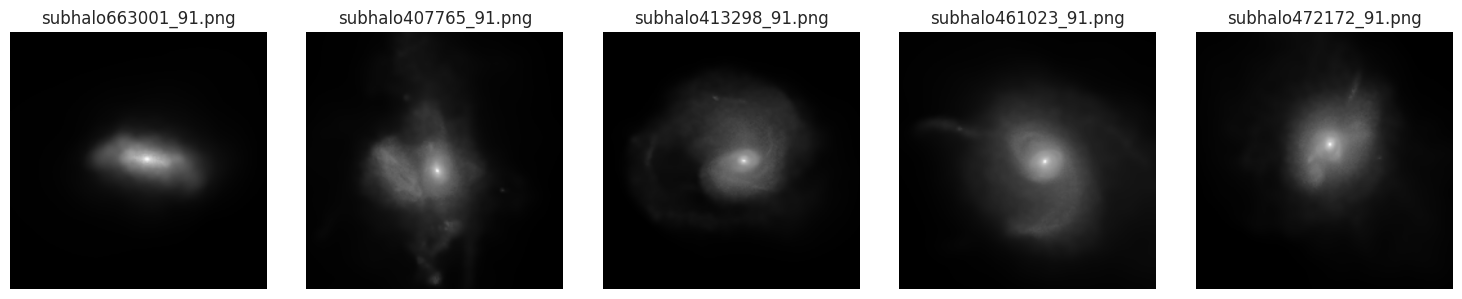

In [ ]:
# 이미지 시각화

image_files = df_img_paths.tolist()[:5]

plt.figure(figsize=(15, 3))
for i, img_path in enumerate(image_files):
    img = Image.open(img_path)
    plt.subplot(1, len(image_files), i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path))  # 파일 이름만 표시
plt.tight_layout()
plt.show()


In [ ]:
# 이미지 전처리 정의
transform = T.Compose([
    # 해상도 조절 (리사이즈)
    T.Resize((256, 256)),

    # Crop (중앙 crop)
    T.CenterCrop(224),

    # 픽셀화 효과
    T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),

    # Tensor로 변환
    T.ToTensor(),

    # 픽셀값 정규화
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# **MultiModal 구조체**

In [ ]:
# ===============================
# 커스텀 PyTorch Dataset 정의
# ===============================
class MultimodalDataset(Dataset):
    def __init__(self, image_paths, tabular_datas, label, transform):
        self.image_paths = image_paths
        self.tabular_datas = tabular_datas
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # 연속형 표 데이터 처리
        tabular_row = self.tabular_datas.iloc[idx].values if isinstance(self.tabular_datas, pd.DataFrame) else self.tabular_datas[idx]
        tabular = torch.tensor(tabular_row, dtype=torch.float32)

        # 라벨 처리
        label_value = self.label.iloc[idx] if isinstance(self.label, pd.Series) else self.label[idx]
        label = torch.tensor(label_value, dtype=torch.long)

        return image, tabular, label


# 전처리된 이미지 저장하는 코드 필요


In [ ]:
# ================================
# PyTorch Lightning DataModule 정의
# ================================
class MultimodalDataModule(pl.LightningDataModule):
    """
    학습 및 검증용 데이터 로더 제공
    """
    def __init__(self, train_dataset, val_dataset, batch_size=5):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

In [ ]:
class MultimodalZoobotModel(FinetuneableZoobotAbstract):
    """
    Zoobot 이미지 인코더 + 수치형 MLP + 새로운 classification head
    """
    def __init__(self, name, n_blocks, learning_rate, lr_decay,
                 tabular_input_dim, tabular_embed_dim, num_classes, image_embed_dim):
        super().__init__(name=name, n_blocks=n_blocks, learning_rate=learning_rate, lr_decay=lr_decay)

        # 수치형 데이터 벡터화 - 복잡도는 실험해봐야 함
        self.tabular_branch = nn.Sequential(
            nn.Linear(tabular_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, tabular_embed_dim)
        )

        # 이미지 + 수치 임베딩을 결합하여 분류하는 head - 복잡도는 실험해봐야 함
        self.head = nn.Sequential(
            nn.Linear(image_embed_dim + tabular_embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )


        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, image, tabular):
        image_embed = self.encoder(image)  # shape: (B, image_embed_dim)
        tabular_embed = self.tabular_branch(tabular)  # shape: (B, tabular_embed_dim)
        combined = torch.cat([image_embed, tabular_embed], dim=1)
        print(f"combined shape: {combined.shape}")  # 디버깅 출력
        return self.head(combined)

    def training_step(self, batch, batch_idx):
      image, tabular, label = batch
      logits = self(image, tabular)
      loss = self.loss_fn(logits, label)
      self.log("train_loss", loss)
      return loss

    def validation_step(self, batch, batch_idx):
      image, tabular, label = batch
      logits = self(image, tabular)
      loss = self.loss_fn(logits, label)
      acc = (logits.argmax(dim=1) == label).float().mean()
      self.log("val_loss", loss)
      self.log("val_acc", acc)
      return {"loss": loss, "acc": acc}


In [ ]:
class SaveWhenLossSimilarCallback(Callback):
    def __init__(self, threshold=0.01, patience=3, save_path=file_path+"/models"):
        self.threshold = threshold
        self.patience = patience
        self.save_path = save_path
        self.counter = 0

    def on_validation_end(self, trainer, pl_module):
        # train_loss와 val_loss 가져오기
        train_loss = trainer.callback_metrics.get("train_loss")
        val_loss = trainer.callback_metrics.get("val_loss")

        # 둘 다 있어야 비교 가능
        if train_loss is not None and val_loss is not None:
            loss_diff = abs(train_loss - val_loss)
            print(f"[Callback] Loss diff: {loss_diff:.4f}")

            if loss_diff < self.threshold:
                self.counter += 1
                print(f"[Callback] Patience counter: {self.counter}/{self.patience}")
                if self.counter >= self.patience:
                    print(f"[Callback] Saving model to {self.save_path} and stopping training.")
                    torch.save(pl_module.state_dict(), self.save_path)
                    trainer.should_stop = True  # 조기 종료
            else:
                self.counter = 0  # 차이 너무 크면 초기화


# **모델 학습**

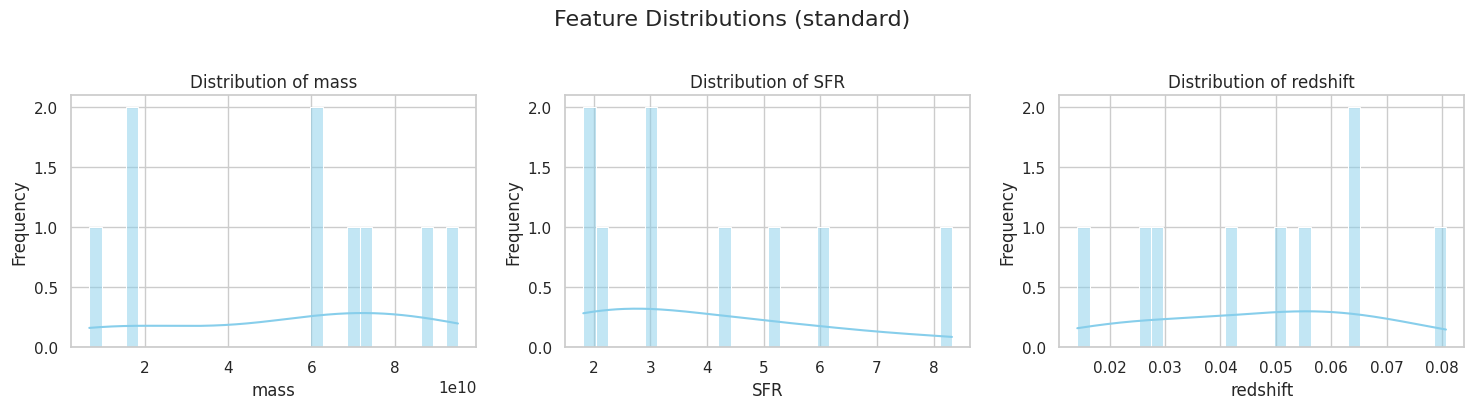

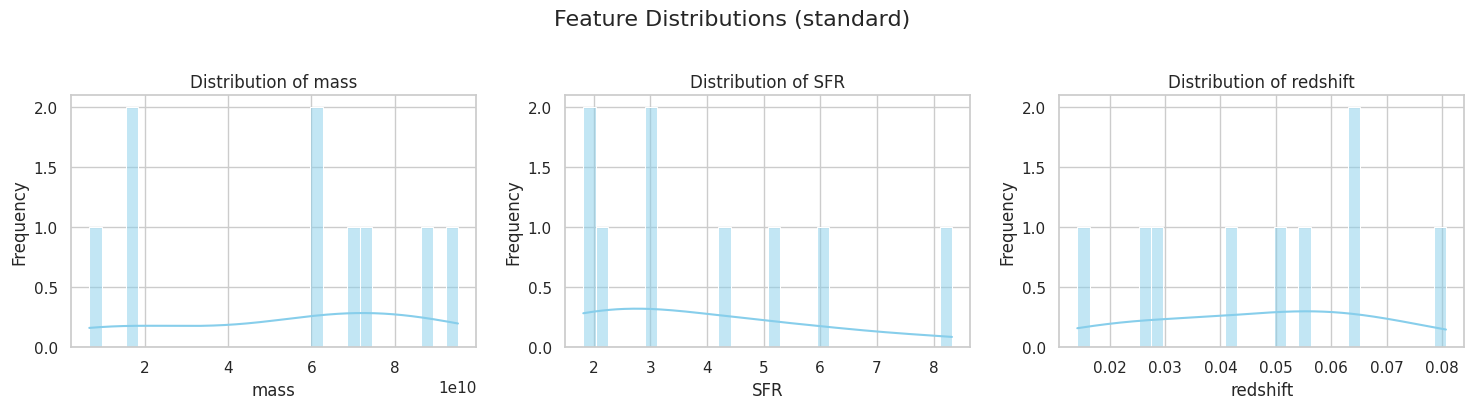

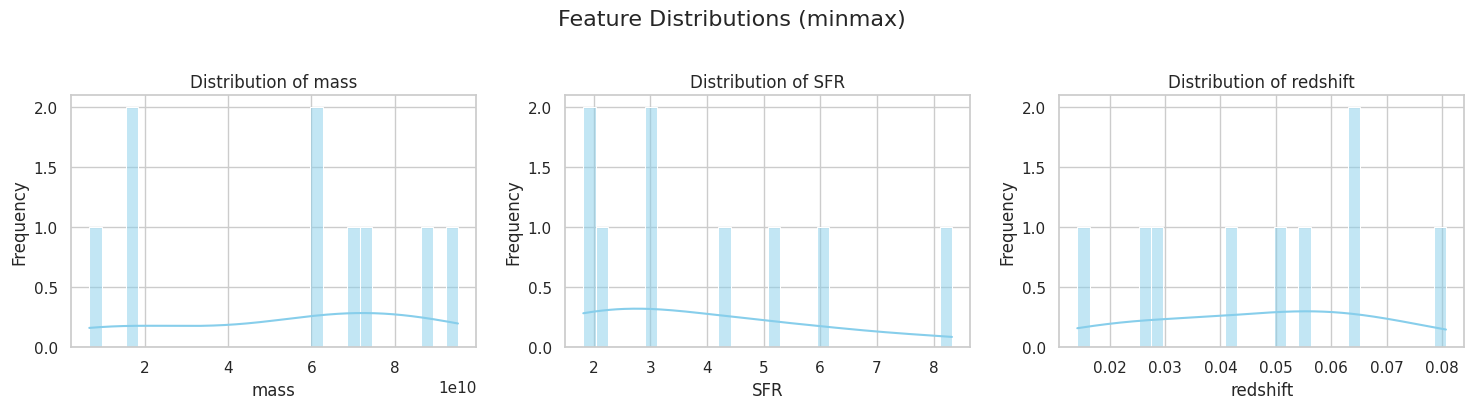

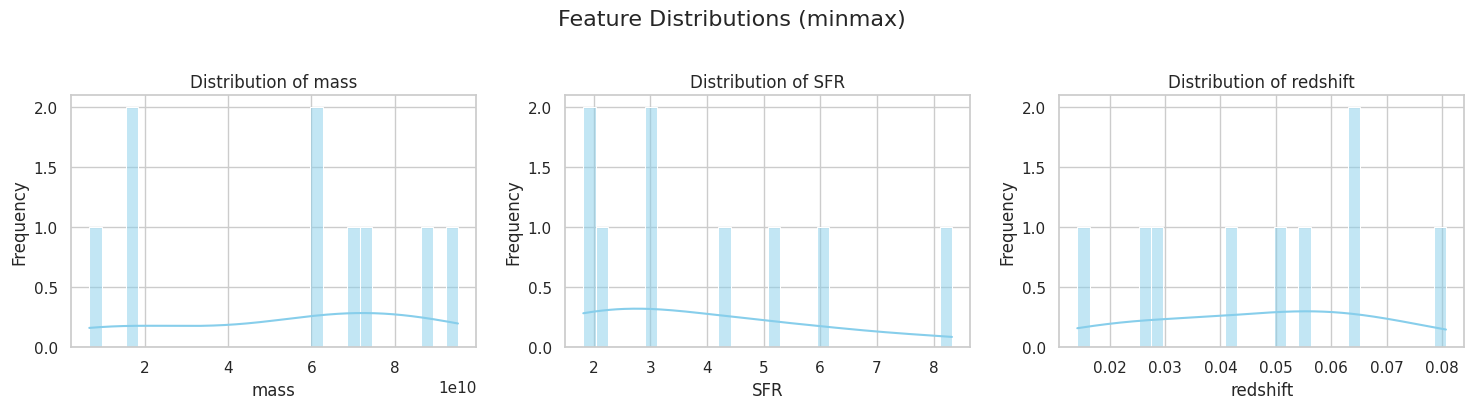

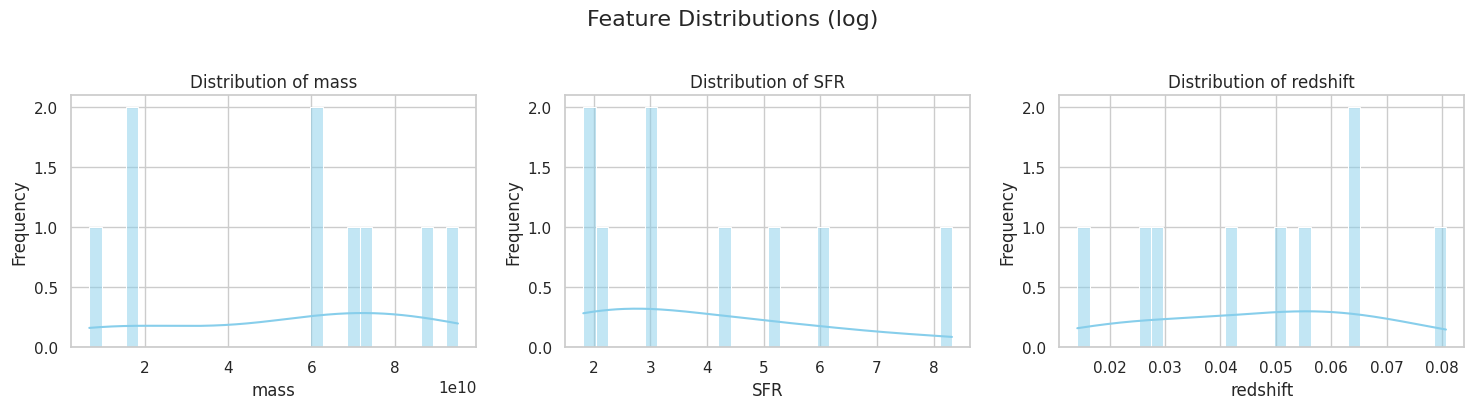

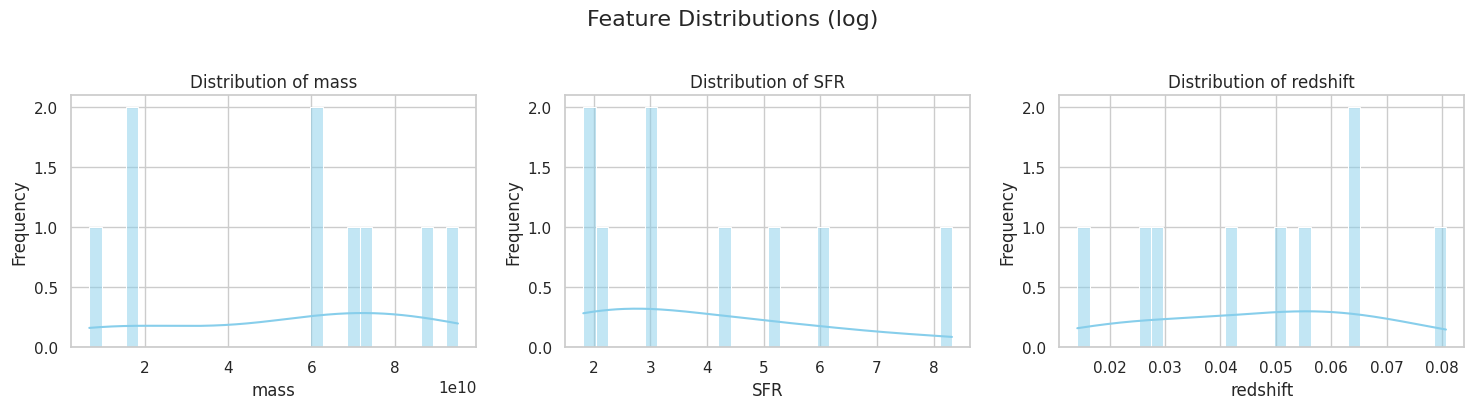

In [ ]:
## 데이터 전처리 ##
scaler_list = ["standard", "minmax", "log"]

for scaler in scaler_list:
  df_scaled_tab_cols = data_preprocessing(df_tab_cols, scaler)

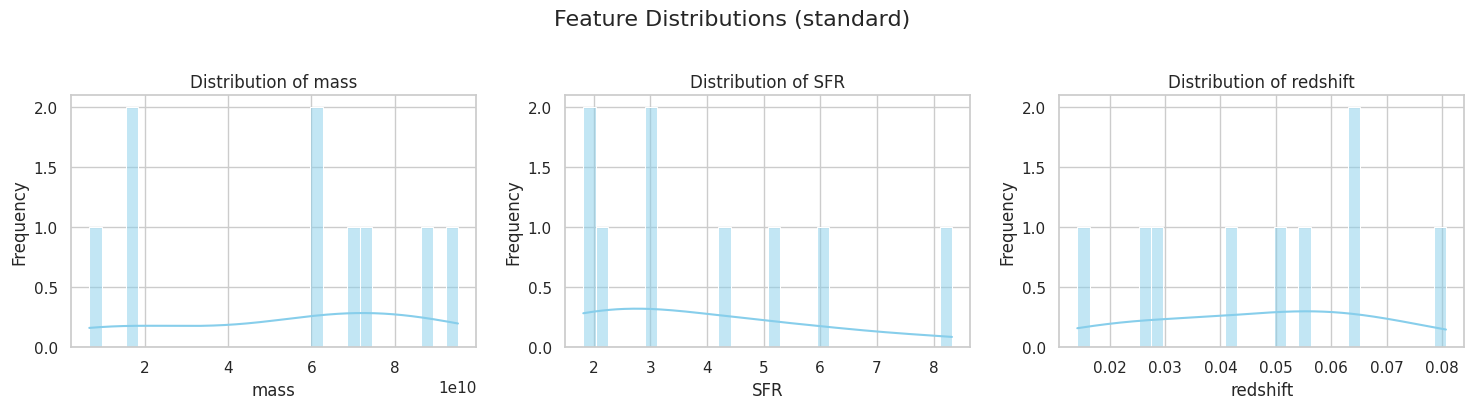

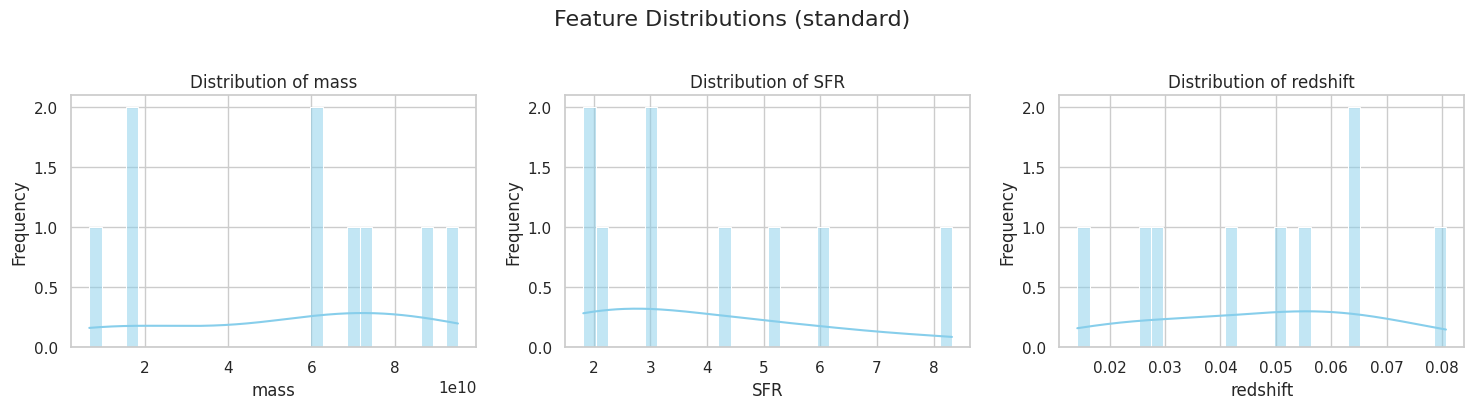

In [ ]:
df_label_col.value_counts()

# 시각화 결과 보고 가장 알맞은 전처리 모델 사용
df_scaled_tab_cols = data_preprocessing(df_tab_cols, "standard")

In [ ]:
def modeling(encoder, save_name, datamodule):
  print("============"+save_name+"===============")
  model = MultimodalZoobotModel(
    name=encoder,
    n_blocks=0,
    learning_rate=1e-5,
    lr_decay=0.5,
    tabular_input_dim= df_scaled_tab_cols.shape[1],
    tabular_embed_dim=3,
    num_classes=3,
    image_embed_dim=640
  )

  #early_stopping_callback = SaveWhenLossSimilarCallback(
      #threshold=0.01,  # 허용 차이
      #patience=3,      # 몇 에폭 동안 유지
      #save_path=file_path+"/models/"+save_name+".pt"
  #)

  # Trainer 정의 및 학습 실행
  #trainer = pl.Trainer(
    #max_epochs=10,
    #accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    #callbacks=[early_stopping_callback]
  #)

  trainer.fit(model, datamodule=datamodule)
  torch.save(model.state_dict(), file_path+"/models/"+save_name+".pt")

In [ ]:
## 모델 학습 ##

# train/val 인덱스 분할
train_idx, val_idx = train_test_split(
    range(len(df)), test_size=0.2, random_state=42
)


train_dataset = MultimodalDataset(
    image_paths=[df_img_paths[i] for i in train_idx],
    tabular_datas=df_scaled_tab_cols.iloc[train_idx].reset_index(drop=True),
    label=df_label_col.iloc[train_idx].reset_index(drop=True),
    transform=transform
)

val_dataset = MultimodalDataset(
    image_paths=[df_img_paths[i] for i in val_idx],
    tabular_datas=df_scaled_tab_cols.iloc[val_idx].reset_index(drop=True),
    label=df_label_col.iloc[val_idx].reset_index(drop=True),
    transform=transform
)


# DataModule 생성
datamodule = MultimodalDataModule(train_dataset, val_dataset, batch_size=5)

encoders = [
   #"hf_hub:mwalmsley/zoobot-encoder-maxvit_rmlp_small_rw_224",
   #"hf_hub:mwalmsley/zoobot-encoder-maxvit_large_tf_224",
   "hf_hub:mwalmsley/zoobot-encoder-convnext_nano",
   #"hf_hub:mwalmsley/zoobot-encoder-convnext_small",
   #"hf_hub:mwalmsley/zoobot-encoder-convnext_base",
   #"hf_hub:mwalmsley/zoobot-encoder-convnext_large"
]

for encoder in encoders:
  save_name = encoder.split("/")[-1]
  modeling(encoder, save_name, datamodule)
  model = MultimodalZoobotModel(
    name=encoder,
    n_blocks=0,
    learning_rate=1e-5,
    lr_decay=0.5,
    tabular_input_dim= df_scaled_tab_cols.shape[1],
    tabular_embed_dim=3,
    num_classes=3,
    image_embed_dim=640
  )

============zoobot-encoder-convnext_nano===============


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/lightning_logs/version_23/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | encoder           | ConvNeXt         | 15.0 M | train
1 | train_loss_metric | MeanMetric       | 0      | train
2 | val_loss_metric   | MeanMetric       | 0      | train
3 | test_loss_metric  | MeanMetric       | 0      | train
4 | tabular_branch    | Sequential       | 451    | train
5 | head              | Sequential       | 82.8 K | train
6 | loss_fn           | CrossEntropyLoss | 0      | train
---------------------------------------------------------------
15.0 M    Trainable params
0         Non-trainable params
15.0 M    Total params
60.143    Total estimated model params size (MB)
214       Modules in train mode
0         Mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


combined shape: torch.Size([2, 643])


In [ ]:
def evaluate_model(model, dataloader, device):
    print("========"+save_name+" evaluation result =========")
    model.eval()  # 평가 모드
    total_loss = 0
    correct = 0
    total = 0

    loss_fn = torch.nn.CrossEntropyLoss()  # 손실 함수 정의 (모델이 내부에 있으면 생략 가능)

    with torch.no_grad():  # 평가 중에는 gradient 계산 비활성화
        for image, tabular, label in dataloader:
            image = image.to(device)
            tabular = tabular.to(device)
            label = label.to(device)

            outputs = model(image, tabular)  # 모델 추론
            loss = loss_fn(outputs, label)

            total_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [ ]:
sample_model = MultimodalZoobotModel(
    name=encoder,
    n_blocks=0,
    learning_rate=1e-5,
    lr_decay=0.5,
    tabular_input_dim= df_scaled_tab_cols.shape[1],
    tabular_embed_dim=3,
    num_classes=3,
    image_embed_dim=640
)

sample_model.load_state_dict(torch.load(file_path+"/models/zoobot-encoder-convnext_nano.pt"))
model.eval()

image_path = 'subhalo482215_91.png'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

from PIL import Image
image = Image.open(file_path+"/galaxy_samples/"+image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0)  # (1, 3, 224, 224)

# 3. 수치형 데이터 전처리
tabular_cols = sample_data.drop(['imagefile', 'phase']).values.astype('float32')
tabular_tensor = torch.tensor(tabular_cols).unsqueeze(0)  # (1, tabular_dim)

# 4. 예측
with torch.no_grad():
    output = sample_model(image_tensor, tabular_tensor)  # (1, num_classes)
    probs = F.softmax(output, dim=1)  # 확률로 변환
    predicted_class = torch.argmax(output, dim=1).item()

print("실제값: ", int(sample_data['phase']))
print("예측 확률:", probs)
print("예측 라벨:", predicted_class)

combined shape: torch.Size([1, 643])
실제값:  0
예측 확률: tensor([[1., 0., 0.]])
예측 라벨: 0
